# Executive Summary: Credit Card Fraud Detection
Core Objective: Develop a high-recall machine learning model to identify fraudulent transactions within a highly imbalanced dataset (0.17% fraud rate)

### The Challenge
Detecting fraud in this dataset is a incredibly hard problem. Standard models often achieve 99.9% accuracy by simply predicting that no transaction is fraud, which is useless for business security. The goal was to find a model that could "see" the subtle patterns hidden within the noise.

### Technical Approach
Model Selection: Leveraged XGBoost for its efficiency with imbalanced tabular data.

SHAP-Driven Engineering: Performed SHAP Interaction Analysis to identify hidden relationships, such as how feat1 only becomes a high-risk signal when paired with specific feat10 values.

Error Analysis: Looked through the data to see where the model was incorrectly marking cases as fraud, then used that to engineer new features to avoid it.

Feature Innovation: Engineered custom interaction terms and behavioral ratios (e.g., Amount / feat3) to simplify complex decision boundaries for the model.

Robust Validation: Validated performance across multiple random seeds (42, 123, 2025) to ensure the engineered signals were stable and not just noise.

## Future Work & Methodology Reflections
If I were to extend this project for production-readiness, I would focus on the following:

1. Robustness Testing (K-Fold Cross-Validation)
While I validated the model across multiple random seeds, a more rigorous approach would involve K-Fold Cross-Validation. This would ensure that the engineered features (like the feat1 interactions) are consistently providing signal across different slices of the data and aren't just over-fitting to a specific train/test split.

2. Feature Ablation Studies
With more time, I would perform a formal Ablation Study—removing one engineered feature at a time and measuring the delta in PR-AUC. This would confirm exactly which "tricks" provided the most lift and which could be pruned to keep the model lean.

3. Hyperparameter Tuning vs. Feature Engineering
While hyperparameter optimization (e.g., tuning scale_pos_weight or max_depth) would likely yield incremental gains, I intentionally prioritized Feature Engineering for this iteration. In fraud detection, a better "feature" almost always beats a better "parameter." My goal was to master the art of uncovering hidden interactions via SHAP, which provides a higher long-term ROI for model development than grid-searching parameters.

4. Automated Feature Selection
I would implement a recursive feature elimination (RFE) process or a "Permutation Importance" check to see if any of the original 28 features have become redundant now that the new interaction terms are doing the heavy lifting.

# Initial Model and Baseline Performance

In [37]:
import kaggle
import zipfile
# Download the data
!kaggle competitions download -c credit-card-fraud-prediction
# Unzip the data
with zipfile.ZipFile("credit-card-fraud-prediction.zip", "r") as zip_ref:
    zip_ref.extractall(".")

# https://www.kaggle.com/competitions/credit-card-fraud-prediction/overview

credit-card-fraud-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [39]:
train.head()

,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount,IsFraud
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Checking how IsFraud is sorted
print(train['IsFraud'].value_counts())

IsFraud
0    149731
1       269
Name: count, dtype: int64


In [42]:
# Checking for missing values
print(train.isnull().sum().sort_values(ascending=False))

id                    0
Time                  0
feat1                 0
feat2                 0
feat3                 0
feat4                 0
feat5                 0
feat6                 0
feat7                 0
feat8                 0
feat9                 0
feat10                0
feat11                0
feat12                0
feat13                0
feat14                0
feat15                0
feat16                0
feat17                0
feat18                0
feat19                0
feat20                0
feat21                0
feat22                0
feat23                0
feat24                0
feat25                0
feat26                0
feat27                0
feat28                0
Transaction_Amount    0
IsFraud               0
dtype: int64


In [43]:
# Checking correlation with IsFraud
print(train.corr(numeric_only=True)['IsFraud'].sort_values(ascending=False))

IsFraud               1.000000
feat28                0.027953
feat4                 0.023601
Transaction_Amount    0.019371
feat11                0.017425
feat18                0.017202
feat20                0.014696
feat9                 0.010629
feat17                0.009585
feat5                 0.007818
feat15                0.007272
feat21                0.006646
feat13                0.000996
feat25                0.000953
feat6                 0.000429
feat2                 0.000131
feat24               -0.001423
id                   -0.002633
feat22               -0.002669
feat27               -0.002914
Time                 -0.004219
feat16               -0.007373
feat19               -0.010128
feat12               -0.014038
feat26               -0.015298
feat23               -0.018681
feat7                -0.019354
feat8                -0.024652
feat10               -0.025478
feat14               -0.033941
feat1                -0.034611
feat3                -0.050245
Name: Is

### Starting XGMBoost model

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

X = train.drop(columns = ['IsFraud', 'id', 'Time']) # id obviously doesn't contribute to the model, Time was also shown through analysis to not contribute
y = train['IsFraud']

# Train/Test Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Since fraud is rare we need to weight fraud cases more heavily
# Calculate scale_pos_weight = non-fraud cases / fraud cases)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print('scale_pos_weight:', scale_pos_weight)

scale_pos_weight: 557.1395348837209


In [45]:
# Creating the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(
    {
        'objective': 'binary:logistic', # We're solving a binary classification problem
        'eval_metric': 'aucpr', #Use AUC-PR (area under precision-recall curve) since fraud is rare
        'scale_pos_weight': scale_pos_weight, # Weight fraud cases more heavily to handle class imbalance
        'eta': 0.01, # Learning rate: how fast the model updates weights (smaller = slower but safer)
        'max_depth': 6, # Maximum depth of each decision tree (controls complexity)
        'subsample': 0.8, # Randomly sample 80% of rows per tree (reduce overfitting)
        'colsample_bytree': 0.8 # Randomly sample 80% of features per tree (adds diversity)
    },
    xgb.DMatrix(X_train, label=y_train), # Training data converted into XGBoost's optimized DMatrix format
    num_boost_round = 200, # Maximum number of boosting rounds (trees to build)
    evals=[ # Tell XGBoost to evaluate performance during training on:
        (dtrain, 'train'), # Training set
        (dval, 'val') # Validation Set
    ],
    early_stopping_rounds = 50,
    verbose_eval=10
)

[0]	train-aucpr:0.02387	val-aucpr:0.00321
[10]	train-aucpr:0.09576	val-aucpr:0.00593
[20]	train-aucpr:0.10569	val-aucpr:0.00676
[30]	train-aucpr:0.10517	val-aucpr:0.00740
[40]	train-aucpr:0.12163	val-aucpr:0.00782
[50]	train-aucpr:0.12479	val-aucpr:0.00849
[60]	train-aucpr:0.13328	val-aucpr:0.00892
[70]	train-aucpr:0.13810	val-aucpr:0.00904
[80]	train-aucpr:0.13983	val-aucpr:0.00922
[90]	train-aucpr:0.14405	val-aucpr:0.00963
[100]	train-aucpr:0.15303	val-aucpr:0.00918
[110]	train-aucpr:0.15779	val-aucpr:0.00871
[120]	train-aucpr:0.16643	val-aucpr:0.00851
[130]	train-aucpr:0.17358	val-aucpr:0.00824
[139]	train-aucpr:0.17994	val-aucpr:0.00830


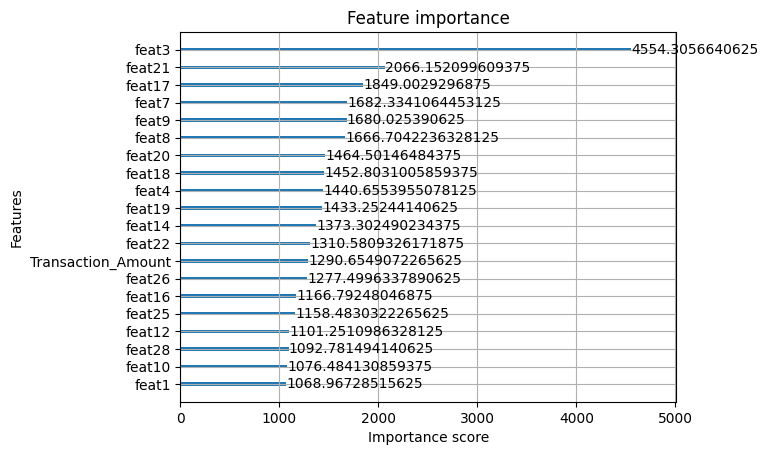

In [46]:
# Quick check for feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=20)
plt.show()

In [47]:
# Evaluating the model

# Predicting probabilities
y_prob = model.predict(dval)

# Threshold at 0.5 for labels

y_pred = (y_prob > 0.5).astype(int)

# Metrics
print(classification_report(y_val, y_pred))
print('ROC-AUC:', roc_auc_score(y_val, y_prob))

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

# PR-AUC score
pr_auc = average_precision_score(y_val, y_prob)
print('PR-AUC:', pr_auc)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     29946
           1       0.01      0.24      0.03        54

    accuracy                           0.97     30000
   macro avg       0.51      0.60      0.50     30000
weighted avg       1.00      0.97      0.98     30000

ROC-AUC: 0.7203045729226187
PR-AUC: 0.009173445177788364


In [48]:
# Total fraud predictions
fraud_predictions = np.sum(y_pred == 1)
print("Number of cases predicted as fraud:", fraud_predictions)

# Compare against actual fraud cases
actual_fraud = np.sum(y_val == 1)
print("Number of actual fraud cases:", actual_fraud)

# Optional: see how many frauds were correctly caught
true_positives = np.sum((y_pred == 1) & (y_val == 1))
print("Number of correctly identified frauds:", true_positives)

Number of cases predicted as fraud: 959
Number of actual fraud cases: 54
Number of correctly identified frauds: 13


In [49]:
print('avg prob not fraud', y_prob[y_val==0].mean())
print('avg prob fraud', y_prob[y_val==1].mean())

avg prob not fraud 0.28161243
avg prob fraud 0.3928456


In [50]:
print("Fraud prob min:", y_prob[y_val==1].min())
print("Fraud prob max:", y_prob[y_val==1].max())

Fraud prob min: 0.15265514
Fraud prob max: 0.7900178


The base model is struggling to differentiate between fraud and non-fraud cases with this dataset. Feature engineering is the best way to help give the model more clues to work with for what separated fraud from non-fraud, so the best course of action is to next look for new features to engineer. Shap plots help us see what features are strong together so that's where i'll go next.

# Shap Interactions and Error Analysis

### Shap Plots

In [51]:
import shap

# Looking for useful interactions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Interaction values
shap_interaction_values = explainer.shap_interaction_values(X_val)

# Get feature names
feature_names = X_val.columns

# Compute mean absolute interaction values
n_features = len(feature_names)
interaction_strengths = []

for i in range(n_features):
    for j in range(i+1, n_features):
        strength = round(float(np.abs(shap_interaction_values[:, i, j]).mean()), 6)
        interaction_strengths.append(((feature_names[i], feature_names[j]), strength))

# Sort by strength
interaction_strengths = sorted(interaction_strengths, key=lambda x: x[1], reverse=True)

# Top 10 strongest interactions
top_interactions = interaction_strengths[:10]
print(top_interactions)


[(('feat3', 'feat10'), 0.043175), (('feat1', 'feat3'), 0.017287), (('feat3', 'feat4'), 0.014367), (('feat1', 'feat10'), 0.011763), (('feat4', 'Transaction_Amount'), 0.011045), (('feat4', 'feat17'), 0.010396), (('feat3', 'feat14'), 0.010175), (('feat3', 'feat26'), 0.009586), (('feat4', 'feat26'), 0.008898), (('feat4', 'feat14'), 0.008582)]


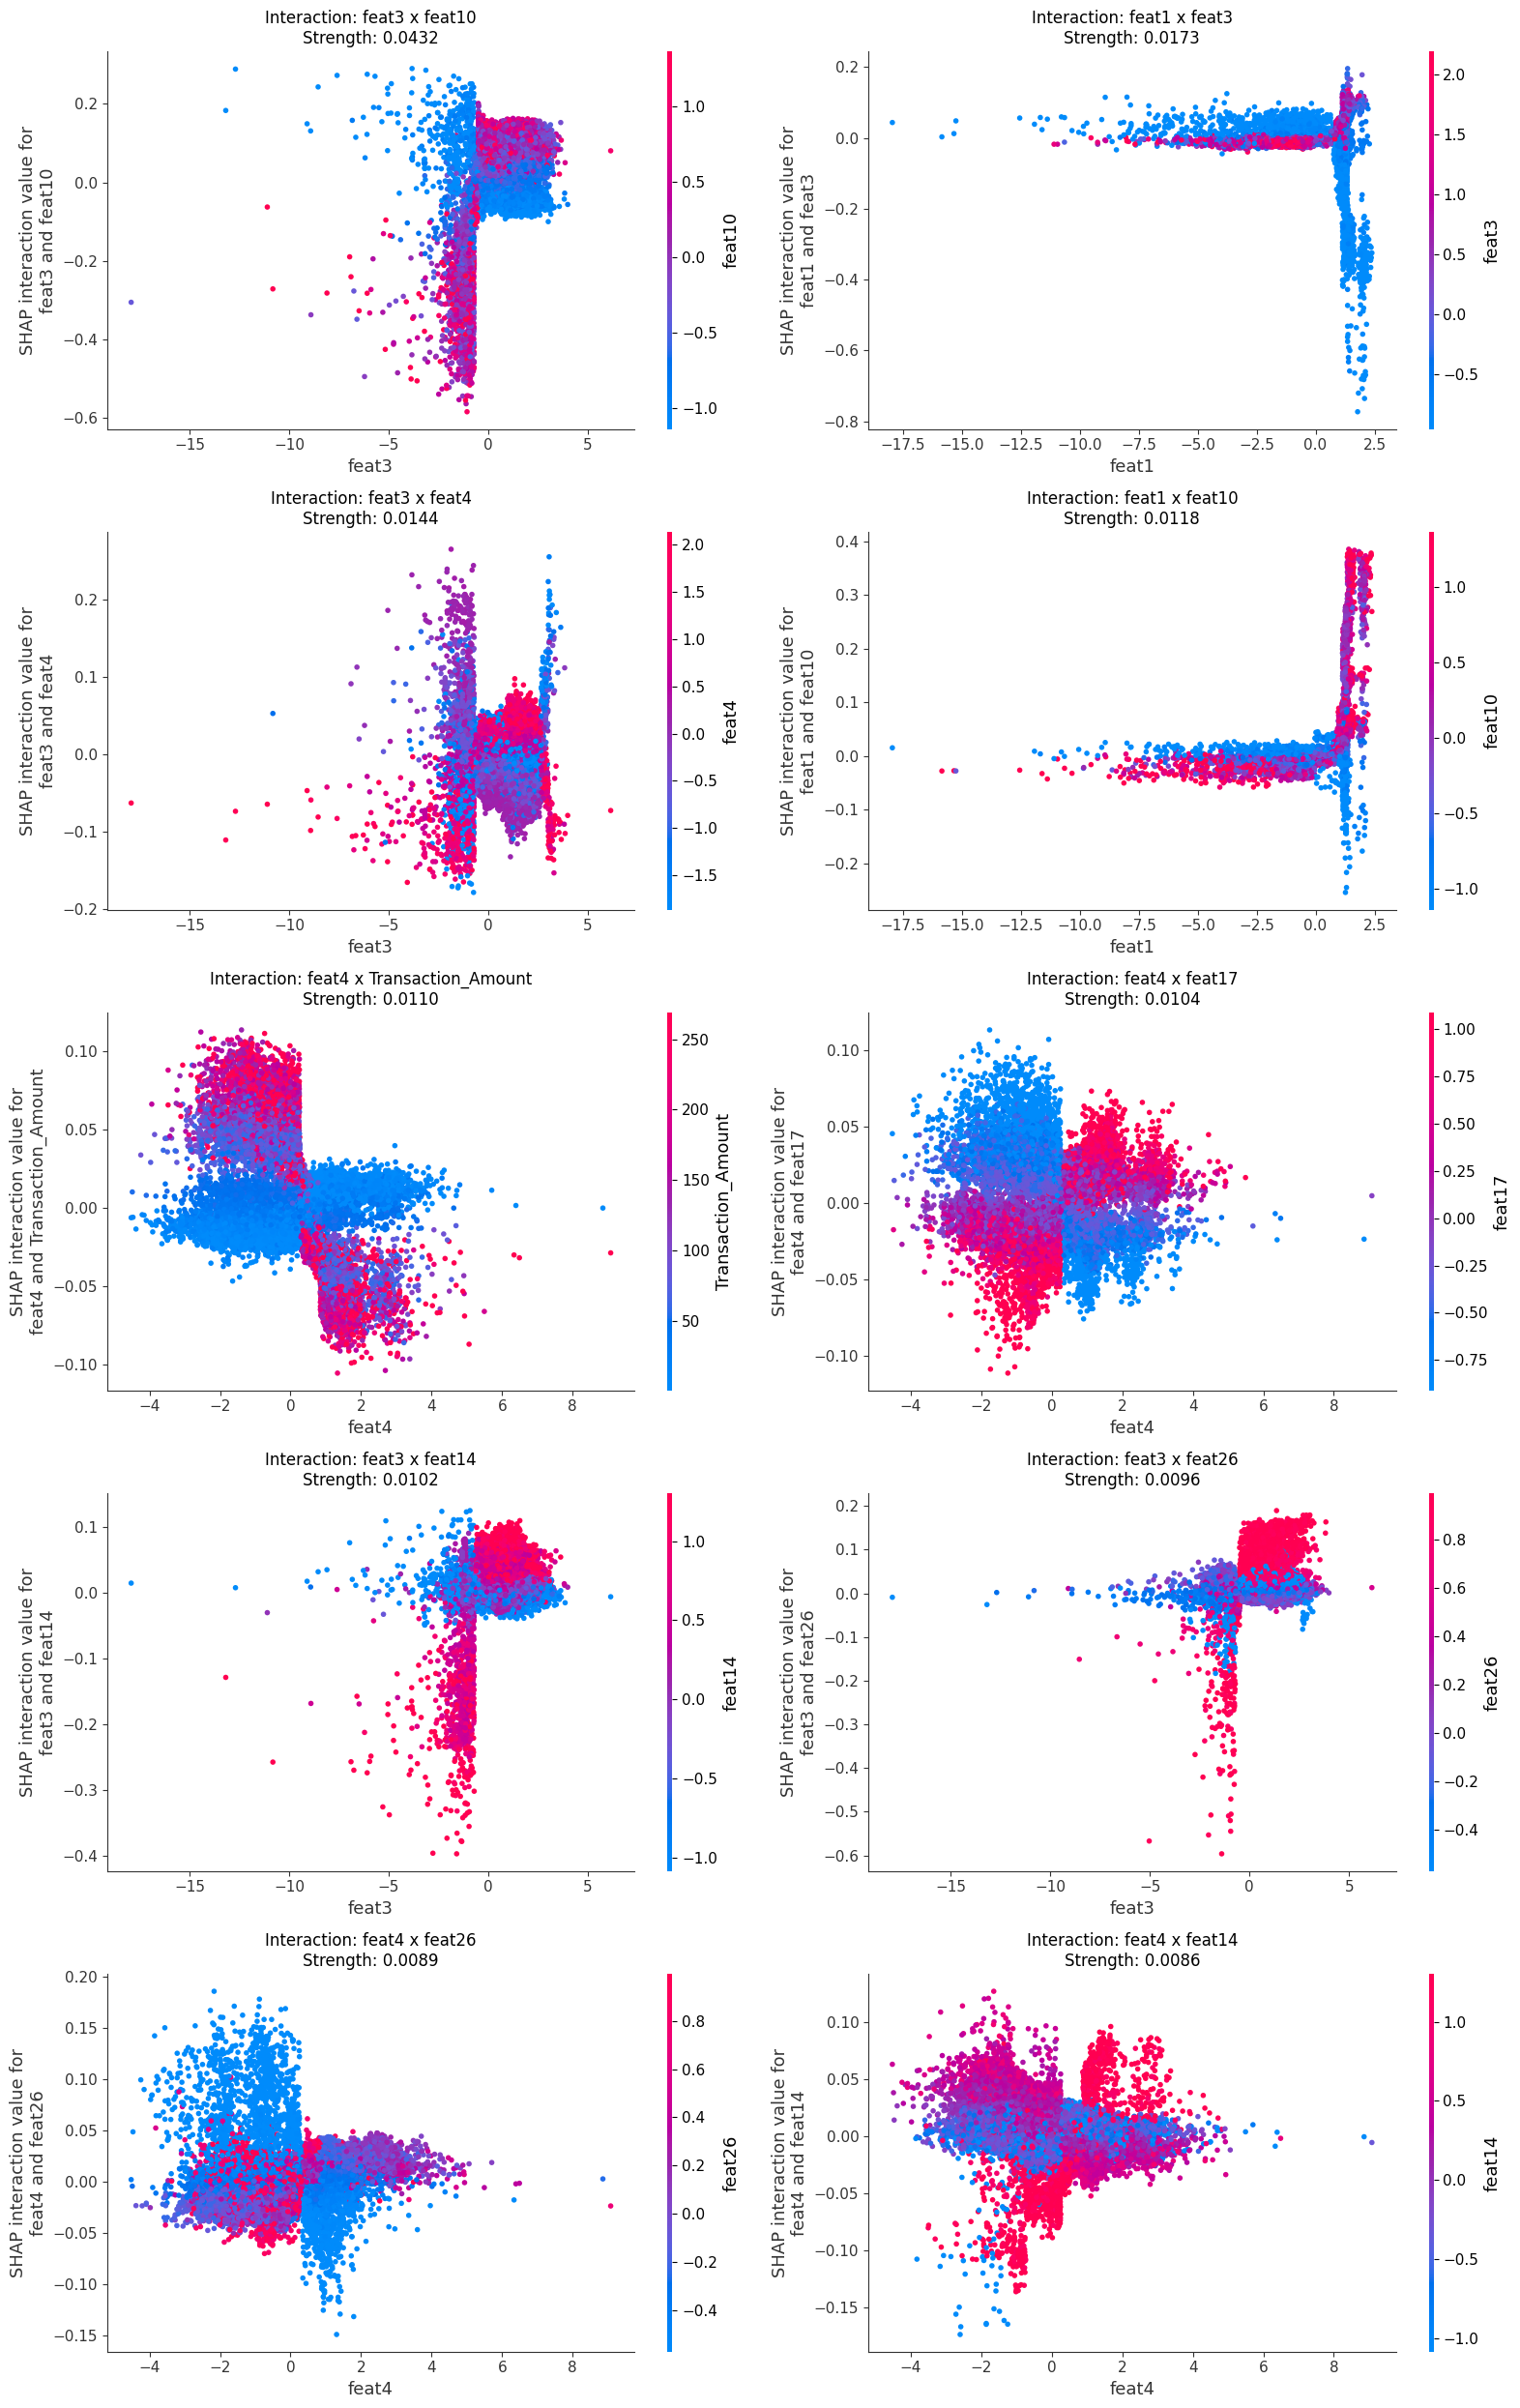

In [52]:
import math
#Plotting the strongest interactions

# 1. Setup the grid dimensions
n_plots = len(top_interactions)
cols = 2
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
axes = axes.flatten()

# 2. Loop through interactions and hand each one to an axis
for i, ((featA, featB), strength) in enumerate(top_interactions):
    shap.dependence_plot(
        (featA, featB), 
        shap_interaction_values, 
        X_val, 
        ax=axes[i], 
        show=False
    )
    axes[i].set_title(f"Interaction: {featA} x {featB}\nStrength: {strength:.4f}")

# 3. Clean up any empty boxes and adjust layout
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The following 2 SHAP plots used to show up in my list of top features but after some code changes they no longer do. Since I added some features based off of them that do help the model i'll explicitly define them so that there is a visual for where I got the idea from.

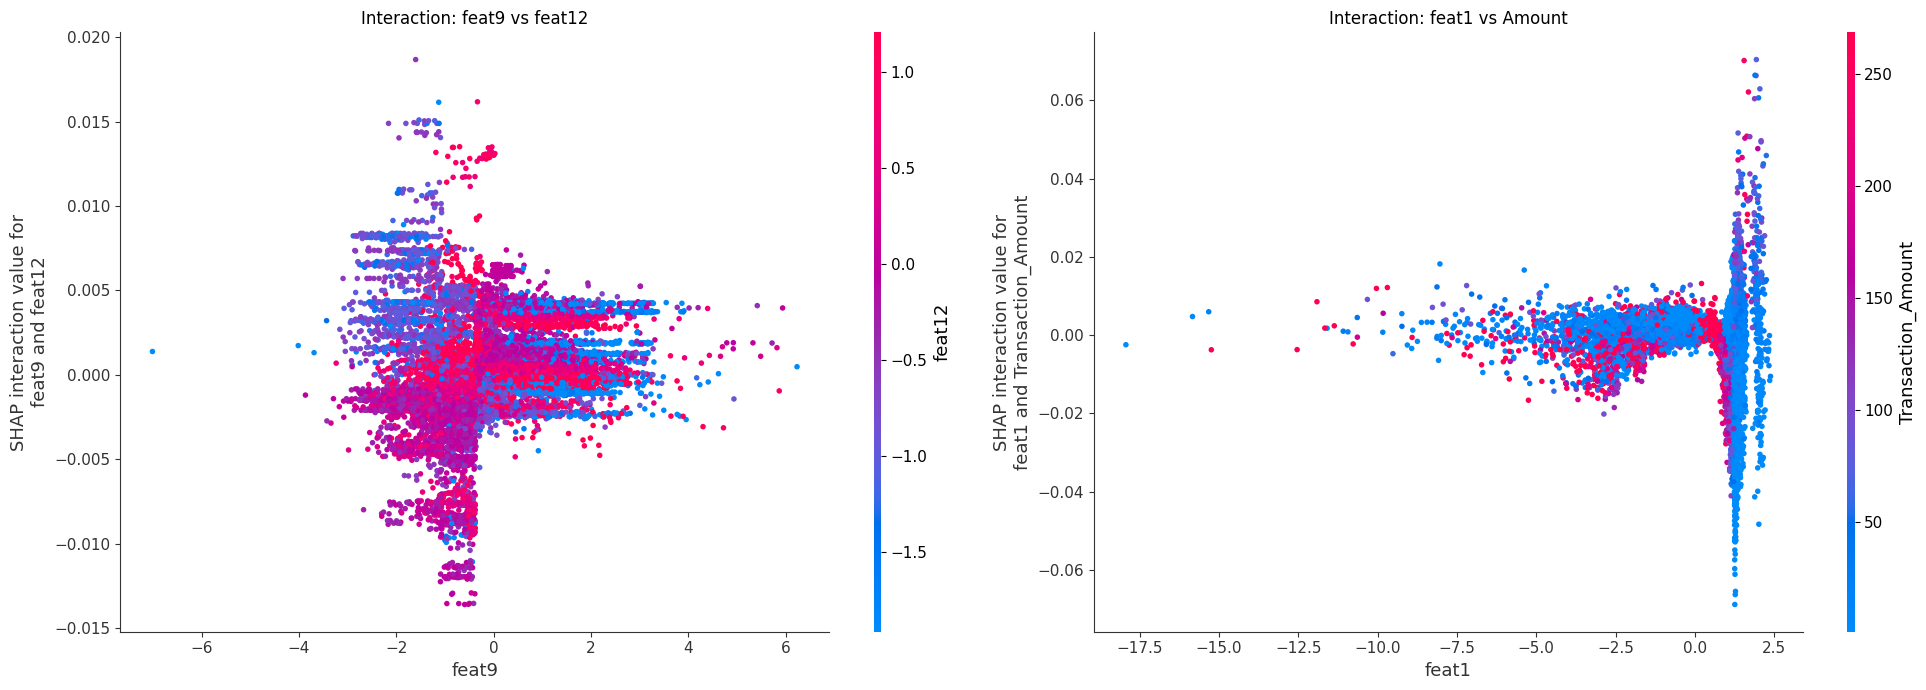

In [53]:
# Create a figure with 2 plots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. Plot for feat9 and feat12 interaction
# We plot feat9 on the X-axis and color it by feat12
shap.dependence_plot(
    ("feat9", "feat12"),
    shap_interaction_values, 
    X_val, 
    interaction_index="feat12", 
    ax=ax1, 
    show=False
)
ax1.set_title("Interaction: feat9 vs feat12")

# 2. Plot for feat1 and Amount interaction
shap.dependence_plot(
    ("feat1", "Transaction_Amount"),
    shap_interaction_values, 
    X_val, 
    interaction_index="Transaction_Amount", 
    ax=ax2, 
    show=False
)
ax2.set_title("Interaction: feat1 vs Amount")

plt.tight_layout()
plt.show()

Based off of these SHAP charts there are a couple of features that I added:

feat1 & feat3
	The SHAP plot between feat1 and feat3 had a very large vertical pillar with low values of feat3, so I added a feature to explicitly separate the red dots from the blue dots in this pillar.
Feat9 & feat12 as well as feat1 & transaction_amount
    Both of these shap plots showed patterns that a simple multiplication between the 2 features added on to the model's performance.

### Error Analysis

In [54]:
# look at the false positives
threshold = 0.4
X_val_analysis = X_val.copy()
X_val_analysis['actual'] = y_val
X_val_analysis['pred_prob'] = y_prob

false_positives = X_val_analysis[(X_val_analysis['actual'] == 0) & (X_val_analysis['pred_prob'] > threshold)]
real_fraud = X_val_analysis[X_val_analysis['actual'] == 1]

# Compare the means of the features
comparison = pd.DataFrame({
    'FP_Median': false_positives.median(),
    'Fraud_Median': real_fraud.median(),
    'FP_Std': false_positives.std(),
    'Fraud_Std': real_fraud.std()
})

comparison['diff_factor'] = (comparison['Fraud_Median'] - comparison['FP_Median']).abs()
print(comparison.sort_values(by='diff_factor', ascending=False).head(10))

                    FP_Median  Fraud_Median      FP_Std   Fraud_Std  \
Transaction_Amount   9.990000      6.970000  221.874169  707.427507   
feat1                1.068069     -0.435984    1.523832    3.284854   
actual               0.000000      1.000000    0.000000    0.000000   
feat3                0.666614     -0.056860    1.352620    3.155508   
feat13              -0.163584      0.160045    1.084082    1.095810   
feat17               0.039896      0.302549    1.056495    1.307858   
feat4                1.042690      0.789349    1.137423    1.542009   
feat5               -0.205936      0.035041    1.174350    1.706211   
feat8                0.171387     -0.058259    1.146327    2.093195   
feat19              -0.189646     -0.380307    0.721250    0.996002   

                    diff_factor  
Transaction_Amount     3.020000  
feat1                  1.504054  
actual                 1.000000  
feat3                  0.723474  
feat13                 0.323630  
feat17        

In [55]:
# Filter to transactions that are actually honest but labeled as likely fraud
confident_fps = X_val_analysis[X_val_analysis['actual'] == 0].sort_values(by='pred_prob', ascending=False).head(10)
# Include the core features of these 10 rows
cols_to_show = ['pred_prob', 'Transaction_Amount', 'feat1', 'feat3', 'feat9_times_feat12']
print("--- Top 10 Most Confident False Positives ---")
print(confident_fps)

--- Top 10 Most Confident False Positives ---
           feat1     feat2     feat3     feat4     feat5     feat6     feat7  \
42053  -1.560150  2.681737 -3.794888  4.692759 -3.067175 -1.957292 -4.071336   
128812 -3.758845  2.886736 -5.686066  4.067181 -4.262755 -2.653836 -3.822776   
51004  -0.231800  2.235812 -2.726243  1.456829  0.588915 -0.794039  0.136440   
98100  -0.085918  1.636574 -1.743869  1.702616  1.396568 -1.162538  0.927390   
17417  -0.582827  1.593667 -0.927248  1.676060  1.032900 -0.949960  0.432913   
1605   -1.425535  2.547785 -2.929366  1.527577  0.090114 -1.717455 -0.146425   
77129  -3.447923  3.071523 -5.058688  4.493369 -1.992638 -2.453801 -0.842809   
106530 -3.597895  4.433432 -5.142355  1.185890 -0.940568 -1.700888 -0.942065   
54973   0.632607  1.967690 -2.546561  1.939753  0.013326 -2.081858  0.009988   
102152 -0.407767  1.829054 -2.043549  1.729926  0.079568 -1.256415  0.456569   

           feat8     feat9    feat10  ...    feat22    feat23    feat24  

In [56]:
# Transpose the top 10 rows so features are rows
analysis_t = confident_fps.T

# Calculate the 'standard deviation' across these 10 rows
# A low Std Dev means all 10 rows have almost the same value for that feature!
analysis_t['consistency'] = analysis_t.std(axis=1)

# Sort by consistency (most similar features at the top)
print("--- Features that are MOST SIMILAR across all Top 10 False Positives ---")
print(analysis_t.sort_values(by='consistency').head(20))

--- Features that are MOST SIMILAR across all Top 10 False Positives ---
              42053    128812     51004     98100     17417      1605  \
actual     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
pred_prob  0.855447  0.847119  0.839040  0.837074  0.834116  0.832899   
feat26    -0.457514 -0.397811 -0.319838 -0.327439 -0.287969 -0.419421   
feat23     0.270817  0.442360  0.111361  0.003315 -0.038549  0.251059   
feat22     0.064402 -0.624271 -0.136959 -0.245559  0.093838 -0.102575   
feat28     0.403548 -0.037826 -0.052717 -0.059906 -0.044780 -0.073269   
feat25    -0.079475 -0.947795 -0.329659  0.058448 -0.386815 -0.361560   
feat20    -0.190979 -0.347949  0.076568  0.084413  0.011540 -0.035241   
feat15     0.695547  1.624828  1.098265  0.581933  1.305877  0.351255   
feat24    -0.097371  0.142826 -0.456750 -0.292923 -0.476761 -0.233096   
feat27     0.554529 -0.005034  0.124549  0.151460  0.131823  0.076193   
feat21     1.042988  1.017869 -0.067881 -0.068589  

In [57]:
# Create a comparison of the Top Mistakes vs Real Fraud
comparison_df = pd.DataFrame({
    'Mistake_Median': confident_fps.median(),
    'Fraud_Median': real_fraud.median()
})

comparison_df['gap'] = (comparison_df['Mistake_Median'] - comparison_df['Fraud_Median']).abs()
# Sort by the biggest gap to find the wedge
print(comparison_df.sort_values(by='gap', ascending=False).head(15))

                    Mistake_Median  Fraud_Median        gap
Transaction_Amount       19.015000      6.970000  12.045000
feat14                   -3.143054      0.050814   3.193868
feat3                    -2.827804     -0.056860   2.770944
feat17                    2.603998      0.302549   2.301449
feat2                     2.391798      0.420938   1.970861
feat6                    -1.709171     -0.091993   1.617178
feat11                    1.951045      0.414888   1.536156
feat10                   -1.344681     -0.198763   1.145918
feat8                     0.952055     -0.058259   1.010314
actual                    0.000000      1.000000   1.000000
feat4                     1.716271      0.789349   0.926923
feat9                    -0.886672      0.040130   0.926802
feat25                   -0.342557      0.307109   0.649666
feat15                    1.071624      0.447935   0.623689
feat18                    1.135170      0.514465   0.620705


In [58]:
invisible_fraud = X_val_analysis[X_val_analysis['actual'] == 1].sort_values(by='pred_prob', ascending=True).head(10)
print("--- Top 10 Fraud Cases the Model Missed (False Negatives) ---")
print(invisible_fraud[['pred_prob', 'Transaction_Amount', 'feat3', 'feat14', 'feat17']])

--- Top 10 Fraud Cases the Model Missed (False Negatives) ---
        pred_prob  Transaction_Amount     feat3    feat14    feat17
70315    0.152655               88.88 -0.440017  0.235959  0.907750
76100    0.156215               51.80  0.958652 -0.293978  0.066362
147942   0.182493              202.50  0.504515  0.274925  0.551330
144930   0.215066                0.01  1.093926 -2.182527 -1.347819
114647   0.224348              500.00  0.060855  0.502909  0.233415
108206   0.235646                5.99  0.636153  0.226966  0.615839
39444    0.241920              482.26  1.174826  0.247965 -0.769346
1681     0.246717              136.58  0.120133  0.393909  1.055578
113144   0.248523                7.06 -1.248086  1.013928  0.397855
28745    0.249428                1.00 -0.083414 -0.157830  0.846002


There were a couple of important observations from this data so here are some insights I made:

feat14 and feat17 both had large gaps between the median value in fraud and the median value in false positive fraud detections, so I made a new feature off of these 2. Goal of these features is to help the model flag less cases as fraud by mistake by making it less reliant on just 1 feature (it was very reliant on feat3 in this case)

feat3 and feat14 had a similar situation as the one above, I made a new feature off of those 2 to try to make the model flag less cases incorrectly as fraud by making it less reliant on feat3, this time by directly associating a feature with feat3.

Feat3 was so dominant that it was overriding some cases of potential fraud, specifically high transaction amounts. While obviously legitimate users do sometimes make big purchases, a big purchase is a potential sign of fraud and feat3 was making the model ignore this case sometimes. Defining a relationship between feat3 and transaction amount helped alleviate this problem.

# Feature Engineering

In [59]:
added_features = ["feat9_times_feat12", 'feat1_high_feat3_low', 'low_amount_negative_feat1', 'feat1_scaled_amount', 'safety_combo_1', 'feat14_to_feat17_ratio', 'refined_fraud_signal', 'high_value_stealth_fraud', 'amount_to_feat3_ratio']

def engineer_features(df):
    df = df.copy()
    # Feat9 and Feat12    
    df["feat9_times_feat12"] = df["feat9"] * df["feat12"]
    low_feat9_12 = df['feat9_times_feat12'].quantile(0.01)
    high_feat9_12 = df['feat9_times_feat12'].quantile(0.99)
    df["feat9_times_feat12"] =  df["feat9_times_feat12"].clip(lower=low_feat9_12, upper=high_feat9_12)
    
    # Feat1 and Feat3
    # Capturing the 'Spike' zone
    df['feat1_high_feat3_low'] = ((df['feat1'] > 1.0) & (df['feat3'] < 0)).astype(int)

    # Targetting the 5-10$ range where fraud median lives
    df['low_amount_negative_feat1'] = ((df['Transaction_Amount'] < 10) & (df['feat1'] < 0)).astype(int)

    # Interactions of the top two continuous signals
    df['feat1_scaled_amount'] = df['feat1'] * df['Transaction_Amount']
    df['feat1_scaled_amount'] = df['feat1_scaled_amount'].clip(lower=-500, upper=500)

    # safety signal for high17 and low14
    df['safety_combo_1'] = ((df['feat14'] < -2) & (df['feat17'] > 2)).astype(int)

    # Ratio feature for feat14 and feat17
    df['feat14_to_feat17_ratio'] = df['feat14'] / (df['feat17'] + 0.00001)

    # Refining fraud signal
    df['refined_fraud_signal'] = ((df['feat3'] < -1) & (df['feat14'] > -1)).astype(int)

    # Targeting high amount fraud that looks legit
    df['high_value_stealth_fraud'] = ((df['Transaction_Amount'] > 200) & (df['feat3'] > 0)).astype(int)
    # interaction between feat3 and the amount
    df['amount_to_feat3_ratio'] = df['Transaction_Amount'] / (df['feat3'] + 1.1)
    high_amount_to_feat3_ratio = df['amount_to_feat3_ratio'].quantile(0.99)
    low_amount_to_feat3_ratio = df['amount_to_feat3_ratio'].quantile(0.01)
    df['amount_to_feat3_ratio'] = df['amount_to_feat3_ratio'].clip(lower=low_amount_to_feat3_ratio, upper=high_amount_to_feat3_ratio)

    return df

X_train, X_val = [engineer_features(df) for df in [X_train, X_val]]

# Final Model Tuning: Feature validation and Threshold Tuning

In [60]:
# Checking if the features contribute to the model by looking at multiple different seeds due to low sample size of fraud
seeds = [42, 123, 2025]
# re-create the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

for seed in seeds:
    print(f"\n" + "="*30)
    print(f"RUNNING MODEL WITH SEED: {seed}")
    print("="*30)
    
    # Define parameters with the changing seed
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'scale_pos_weight': scale_pos_weight,
        'eta': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': seed  # This ensures the "randomness" changes each loop
    }

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict
    y_prob = model.predict(dval)
    y_pred = (y_prob > threshold).astype(int)

    # Calculate Global Metrics
    roc_auc = roc_auc_score(y_val, y_prob)
    pr_auc = average_precision_score(y_val, y_prob)

    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'PR-AUC:  {pr_auc:.4f}')
    print(f'\nMetrics for Threshold {threshold}:')
    print(classification_report(y_val, y_pred))

# Create a new version of the data without those columns
removed_features = ['refined_fraud_signal', 'safety_combo_1', 'low_amount_negative_feat1']
X_train_reduced = X_train.drop(removed_features, axis=1)
X_val_reduced = X_val.drop(removed_features, axis=1)

# Re-create the DMatrices using the REDUCED data
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)
dval = xgb.DMatrix(X_val_reduced, label=y_val)
print("Dropping Refined_fraud_signal and safety_combo_1 and rerunning the seeds:") 

for seed in seeds:
    print(f"\n" + "="*30)
    print(f"RUNNING MODEL WITH SEED: {seed}")
    print("="*30)
    
    # Define parameters with the changing seed
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'scale_pos_weight': scale_pos_weight,
        'eta': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': seed  # This ensures the "randomness" changes each loop
    }

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False # Set to False to keep the output clean
    )

    # Predict
    y_prob = model.predict(dval)
    y_pred = (y_prob > threshold).astype(int)

    # Calculate Global Metrics
    roc_auc = roc_auc_score(y_val, y_prob)
    pr_auc = average_precision_score(y_val, y_prob)

    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'PR-AUC:  {pr_auc:.4f}')
    print(f'\nMetrics for Threshold {threshold}:')
    print(classification_report(y_val, y_pred))


RUNNING MODEL WITH SEED: 42
ROC-AUC: 0.7487
PR-AUC:  0.0119

Metrics for Threshold 0.4:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     29946
           1       0.01      0.54      0.01        54

    accuracy                           0.85     30000
   macro avg       0.50      0.70      0.47     30000
weighted avg       1.00      0.85      0.92     30000


RUNNING MODEL WITH SEED: 123
ROC-AUC: 0.7241
PR-AUC:  0.0124

Metrics for Threshold 0.4:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     29946
           1       0.00      0.56      0.01        54

    accuracy                           0.71     30000
   macro avg       0.50      0.63      0.42     30000
weighted avg       1.00      0.71      0.83     30000


RUNNING MODEL WITH SEED: 2025
ROC-AUC: 0.7299
PR-AUC:  0.0117

Metrics for Threshold 0.4:
              precision    recall  f1-score   support

           0       1.

While the first model works better when include the features refined_fraud_signal and safety_combo_1, if we look across multiple seeds then the average model performance is worse with those features included. This is because the low sample size of fraud makes it so that the model changes somewhat sporadically whenever anything is changed because the model will split at different spots. 

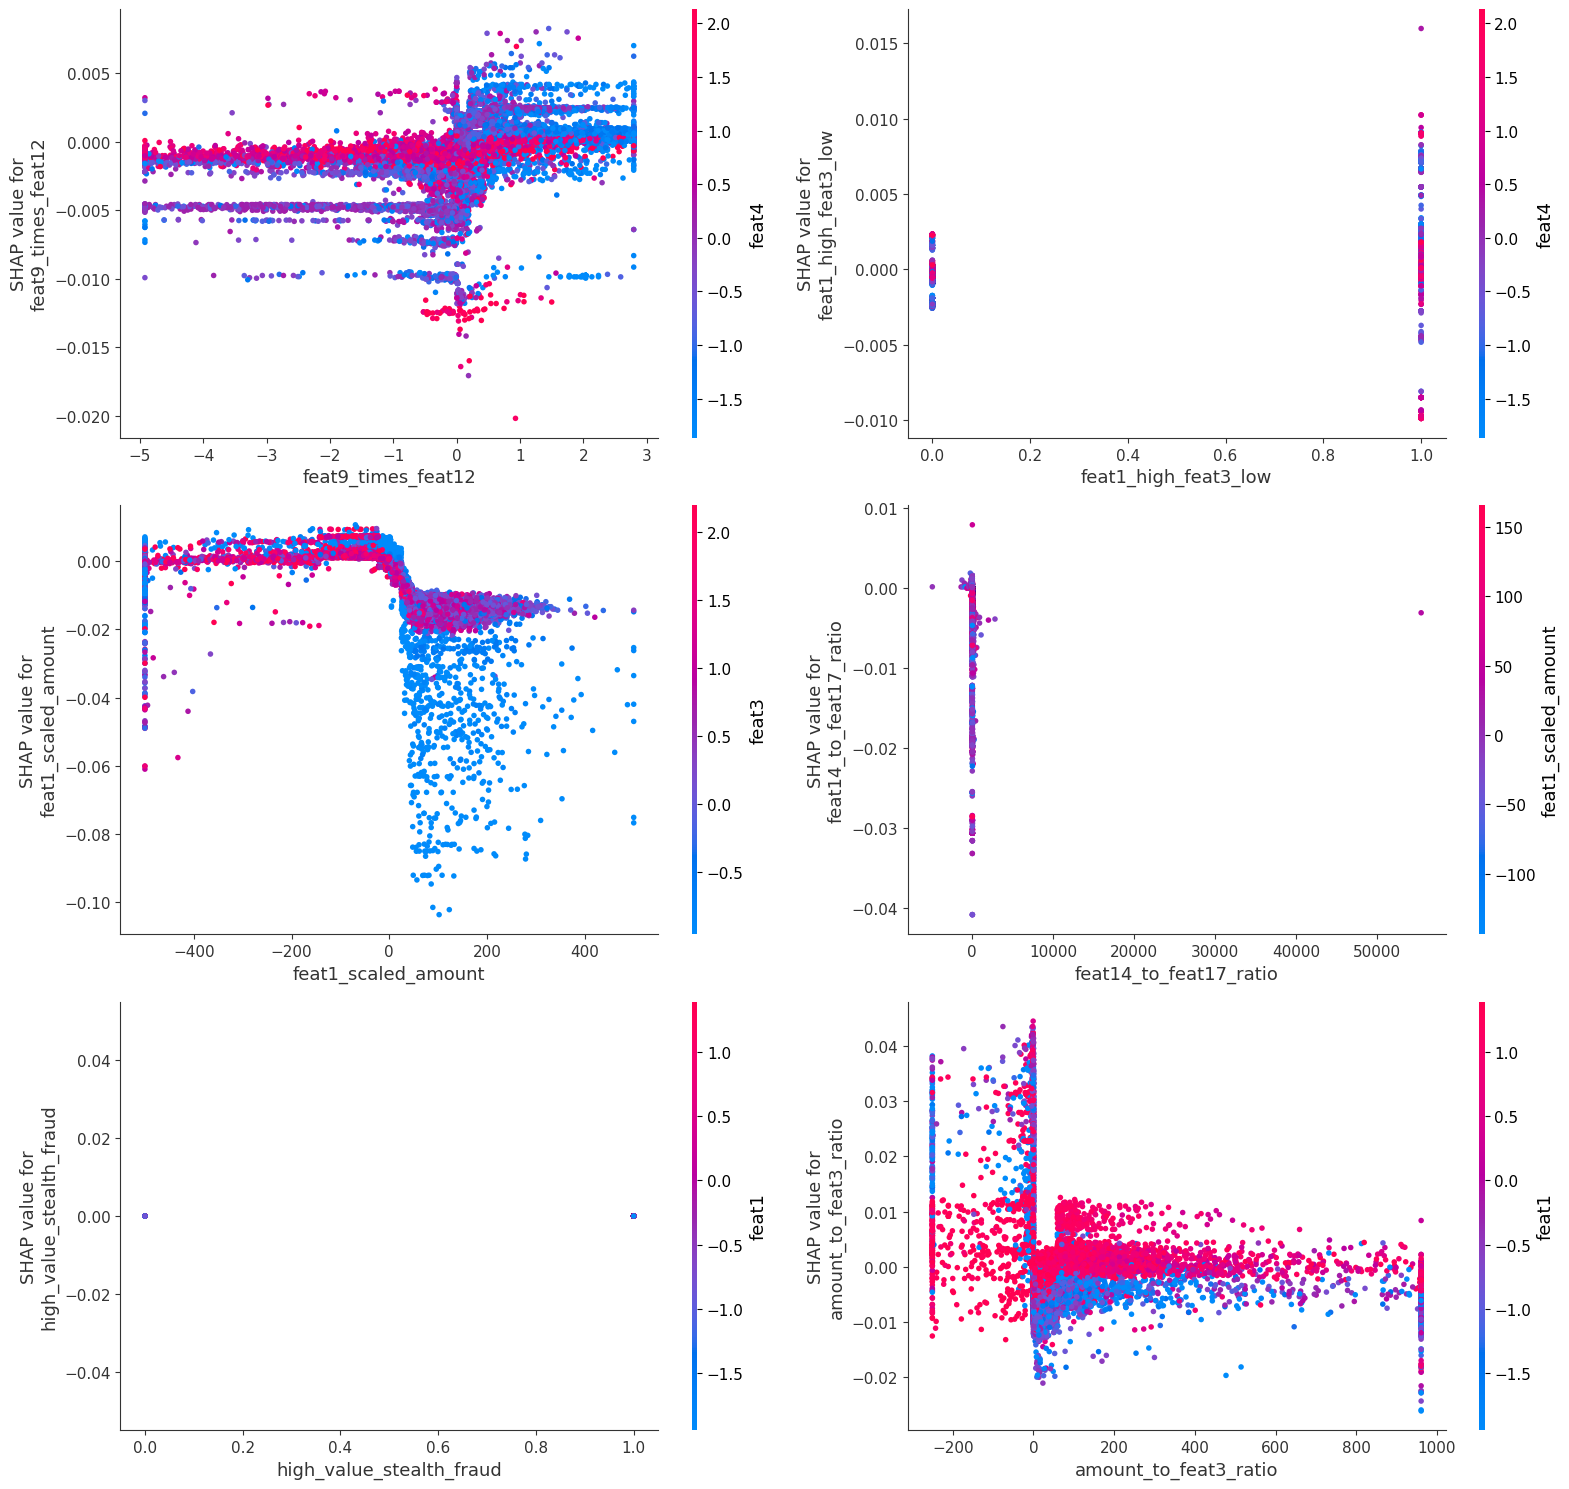

In [61]:
# Recalculate SHAP values
explainer = shap.TreeExplainer(model)
new_shap_values = explainer.shap_values(X_val_reduced)

# Shap dependence plots for new features

# Looking at the reduced list of added features
final_added_features = [f for f in added_features if f not in removed_features]

cols = 2
rows = math.ceil(len(final_added_features) / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 5*rows))
axes = axes.flatten()

# 2. Loop and "Hand" the axis to SHAP
for i, feature in enumerate(final_added_features): 
    shap.dependence_plot(feature, new_shap_values, X_val_reduced, ax=axes[i], show=False)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
# 3. Final display
plt.tight_layout()
plt.show()

While this chart makes it look like high_value_stealth_fraud is not being used in the model, that is due to these charts only being shown for the most recent seed of the model. On average the feature was being used in the model and has a positive effect. This is again another aspect that smaller data have that make them harder to work with.

In [62]:
# Get importance based on 'Gain' (improvement in accuracy)
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False)

print(importance_df)

                   Feature         Gain
2                    feat3  6660.681152
33   amount_to_feat3_ratio  4140.595703
20                  feat21  2550.368408
3                    feat4  2526.663086
17                  feat18  2200.097412
8                    feat9  2191.868164
7                    feat8  2166.089844
18                  feat19  2090.632568
16                  feat17  1954.761353
6                    feat7  1868.105347
13                  feat14  1830.407227
25                  feat26  1733.640625
28      Transaction_Amount  1703.883667
9                   feat10  1688.921021
21                  feat22  1674.880981
27                  feat28  1670.023438
11                  feat12  1649.078735
24                  feat25  1540.725830
22                  feat23  1473.310791
19                  feat20  1467.587769
31     feat1_scaled_amount  1435.967041
5                    feat6  1431.292969
4                    feat5  1357.262817
26                  feat27  1333.589233


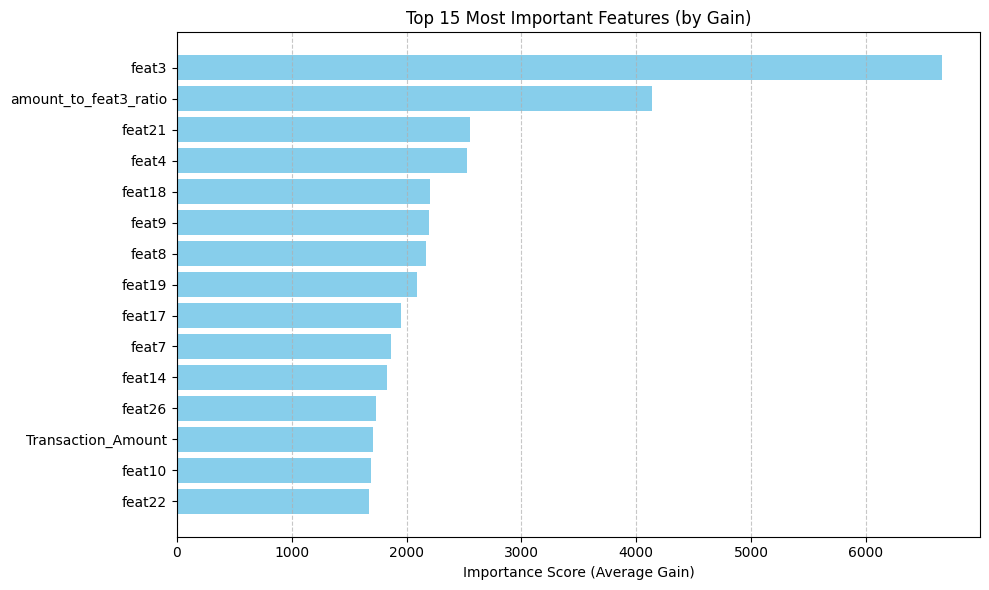

In [63]:
plt.figure(figsize=(10, 6))
top_15 = importance_df.head(15).iloc[::-1] # reverses it so the most important features are at the top of the chart

plt.barh(top_15['Feature'], top_15['Gain'], color='skyblue')
plt.title("Top 15 Most Important Features (by Gain)")
plt.xlabel("Importance Score (Average Gain)")
plt.grid(axis='x', linestyle='--', alpha=0.7) # Added for better scannability
plt.tight_layout()
plt.show()

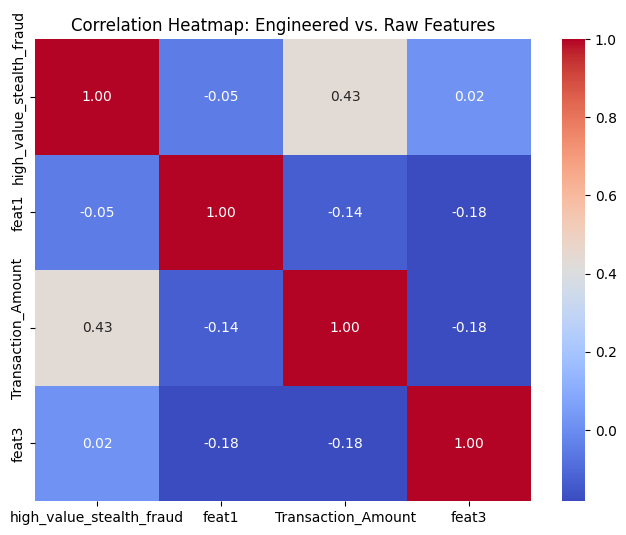

In [64]:
# Checking that features aren't redundant
features_to_check = ['high_value_stealth_fraud', 'feat1', 'Transaction_Amount', 'feat3']
corr_matrix = X_train[features_to_check].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Engineered vs. Raw Features")
plt.show()

This chart was mostly to see if high_value_stealth_fraud was contributing to the model despite having a very small importance score and not at all on the current seed. This feature is there as a safety net for a few large outlier fraud cases allowing the model to detect it as fraud without confusing the rest of the model. Because of the small dataset, these outlier fraud cases aren't going to show up in every seed so that's why it isn't used sometimes. The correlation between high_value_stealth_fraud and other important features isn't very high, meaning that this new feature is catching parts of the data that the original features by themselves were not catching.

In [65]:
# Checking for optimal threshold

# Predicting probabilities
y_prob = model.predict(dval)

# Threshold for marking as fraud
thresholds = [.3, .35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
threshold = 0.4
print('ROC-AUC:', roc_auc_score(y_val, y_prob))
# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_prob)
        
# PR-AUC score
pr_auc = average_precision_score(y_val, y_prob)
print('PR-AUC:', pr_auc)

for val in thresholds:
    y_pred = (y_prob > val).astype(int)
        
    # Metrics 
    print('Metrics for y_pred = ', val)
    print(classification_report(y_val, y_pred))

ROC-AUC: 0.7495430045687175
PR-AUC: 0.010650236207137247
Metrics for y_pred =  0.3
              precision    recall  f1-score   support

           0       1.00      0.07      0.13     29946
           1       0.00      1.00      0.00        54

    accuracy                           0.07     30000
   macro avg       0.50      0.53      0.06     30000
weighted avg       1.00      0.07      0.13     30000

Metrics for y_pred =  0.35
              precision    recall  f1-score   support

           0       1.00      0.37      0.54     29946
           1       0.00      0.91      0.01        54

    accuracy                           0.37     30000
   macro avg       0.50      0.64      0.27     30000
weighted avg       1.00      0.37      0.54     30000

Metrics for y_pred =  0.4
              precision    recall  f1-score   support

           0       1.00      0.65      0.79     29946
           1       0.00      0.69      0.01        54

    accuracy                           0.65   

For this I think the optimal threshold is 0.4, but that could change depending on the goals. At a 0.4 threhsold we are catching nearly 70% of fraud and clearing 65% of legit users. A lower threshold leads to more fraud being caught (91% at 0.35 and 100% at 0.3) but also flags 63% of legitimate users as fraud at a 0.35 threshold. If the bank had a ton of employees to go through these cases individually and sort out if it was fraud or not then flagging more as possible fraud would fit their ideal scenario, and so a lower threshold should be chosen. At higher thresholds less fraud is detected (46% of fraud at 0.45 and <15% past that) but there are much less legit users that are being marked for possible fraud. If there was not very much staff available to go through these cases then maybe that would be the ideal scenario for them.

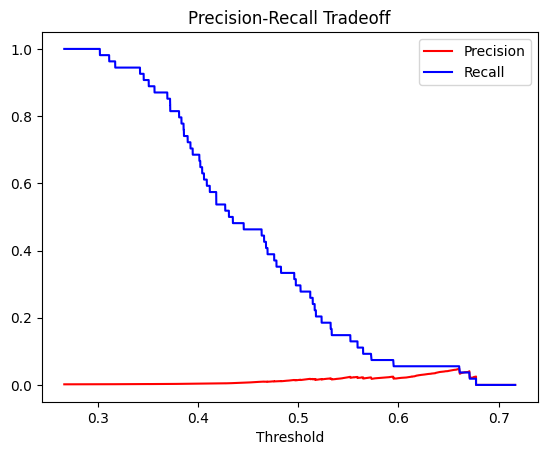

In [66]:
precision, recall, pr_thesholds = precision_recall_curve(y_val, y_prob)

plt.plot(pr_thresholds, precision[:-1], label = 'Precision', color='red')
plt.plot(pr_thresholds, recall[:-1], label='Recall', color='blue')
plt.xlabel('Threshold')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

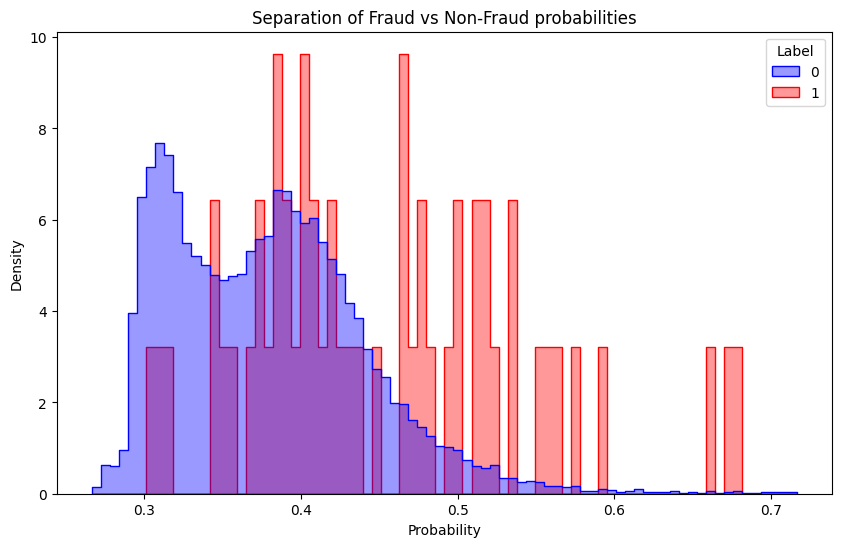

In [67]:
# Making a chart to see the distribution

plot_df = pd.DataFrame({
    'Probability': np.array(y_prob).ravel(),
    'Label': np.array(y_val).flatten()
})

plt.figure(figsize=(10,6))

sns.histplot(data=plot_df, x='Probability', hue='Label', element='step', stat='density', common_norm=False, palette={0: 'blue', 1: 'red'}, alpha=0.4)

plt.title('Separation of Fraud vs Non-Fraud probabilities')
plt.show()

This is a good visual of where the model is struggling. Right around .4 is where there is both a lot of fraud and non-fraud activity. More work being done to help separate these cases out of the same probability would help the model out a lot.

In [68]:
check_df = pd.DataFrame({
    'Probability': np.array(y_prob).ravel(),
    'Actual_label': np.array(y_val).ravel()
})

means = check_df.groupby('Actual_label')['Probability'].mean()

print('Mean Predicted Probability per Class:')
print(means)

Mean Predicted Probability per Class:
Actual_label
0    0.378728
1    0.453043
Name: Probability, dtype: float32


# Final Submission

In [69]:
X_test_final = test.copy()
X_test_final = X_test_final.drop(['id', 'Time'], axis=1)
X_test_final = engineer_features(X_test_final)
X_test_final = X_test_final.drop(removed_features, axis=1)

dtest_final = xgb.DMatrix(X_test_final)
test_probs = model.predict(dtest_final)

In [70]:
submission = pd.DataFrame({
    'id': test['id'], 
    'Class': test_probs
})
submission.to_csv('my_fraud_submission.csv', index=False)